# YOLOv3 Object detection
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [YOLOv3_object_detection.ipynb](https://github.com/diegoinacio/computer-vision-notebooks/blob/master/Computer-Vision-Experiments/YOLOv3_object_detection.ipynb)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import cv2

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## Get the dataset
---

In [ ]:
# Getting label names
!curl --progress-bar -O https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

In [ ]:
# Getting cfg
!curl --progress-bar -O https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

In [ ]:
# Getting weights
!curl --progress-bar -O https://pjreddie.com/media/files/yolov3.weights

## Read and prepare data
---

In [3]:
###########
# Classes #
###########
# Read classes
CLASSES = []
with open("coco.names", "r") as f:
    CLASSES = [line.strip() for line in f.readlines()]

# Define colors for each class
np.random.seed(123456)
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))
COLORS /= (np.sum(COLORS**2, axis=1)**0.5/255)[np.newaxis].T

#########
# Model #
#########
# Build model
MODEL = cv2.dnn.readNet(
    'yolov3.weights',
    'yolov3.cfg'
)

# Get output layers
OUTPUT_LAYERS = [MODEL.getLayerNames()[i[0] - 1] for i in MODEL.getUnconnectedOutLayers()]

In [4]:
# Read input image
IMG_IN = cv2.imread('../_data/f16.png')
b, g, r = cv2.split(IMG_IN)
IMG_IN = cv2.merge((r, g, b))

## Object detection
---

In [5]:
def objectDetection(IMG_IN):
    height, width, channels = IMG_IN.shape
    blob = cv2.dnn.blobFromImage(IMG_IN, 1/255, (416, 416), swapRB=True, crop=False)

    MODEL.setInput(blob)
    outs = MODEL.forward(OUTPUT_LAYERS)

    # Show infos
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                # Rectangle coordinates
                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Draw boxes
    IMG_OUT = IMG_IN.copy()
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(CLASSES[class_ids[i]])
            color = COLORS[class_ids[i]]
            cv2.rectangle(IMG_OUT, (x, y), (x + w, y + h), color, 2)
            cv2.putText(IMG_OUT, label, (x, y - 5), font, 2, color, 2)
    
    return IMG_OUT, label

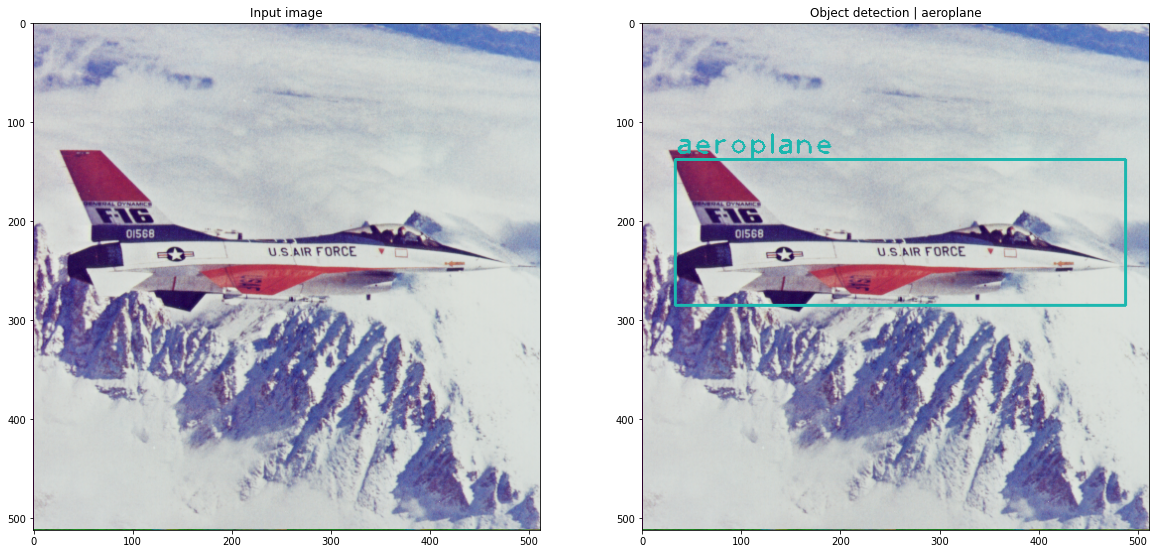

In [6]:
fig, (axA, axB) = plt.subplots(1, 2)

axA.imshow(IMG_IN)
axA.set_title("Input image")

IMG_OUT, label = objectDetection(IMG_IN)
axB.imshow(IMG_OUT)
axB.set_title(f'Object detection | {label}')

plt.show()

## Examples
---

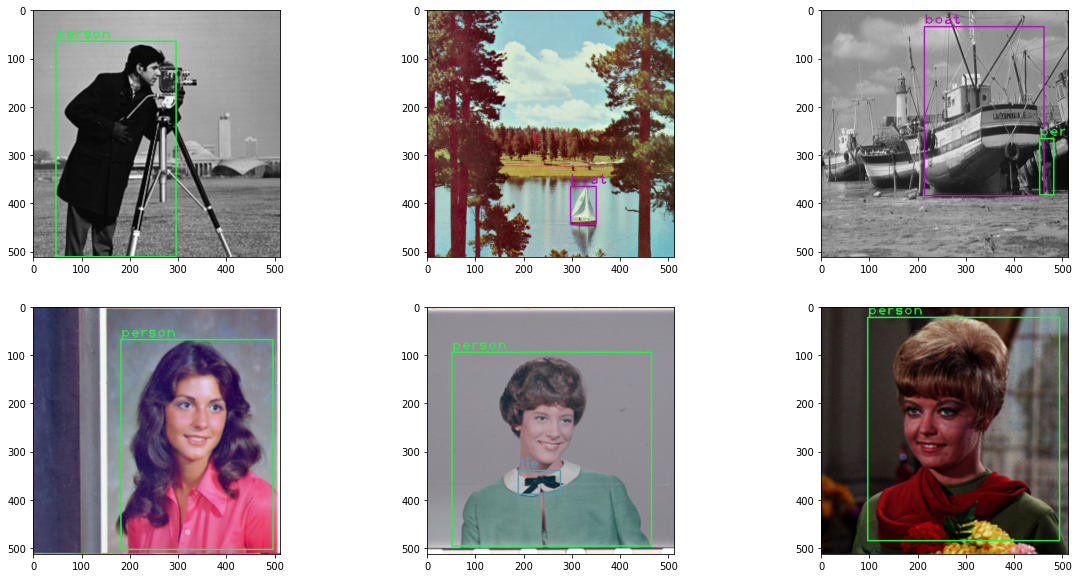

In [7]:
IMGS = ['cameraman', 'sailboat', 'ship', 'woman01', 'woman02', 'woman03']

fig, axs = plt.subplots(2, 3)
axs = [b for a in axs for b in a]

for i, ax in enumerate(axs):
    IMG_IN = cv2.imread(f'../_data/{IMGS[i]}.png')
    b, g, r = cv2.split(IMG_IN)
    IMG_IN = cv2.merge((r, g, b))

    IMG_OUT, label = objectDetection(IMG_IN)
    ax.imshow(IMG_OUT)